# Pre-employment coursework
## Exercise 5b - Generative Adversarial Network w/ CIFAR-10

- **Author:** Jan Xu
- **Model:** A DCGAN with WGAN-GP loss
- **Aim:** Model should be trained to generate new instances of one class of the CIFAR-10 training dataset.
- **Sources:** Gulrajani, (2017), *Improved Training of Wasserstein GANs*, https://arxiv.org/pdf/1704.00028.pdf

In [20]:
# Imports
from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

import torchvision
from torchvision.transforms import transforms

from IPython.display import display, clear_output

from utils_CIFAR import *

print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1


## Load the CIFAR dataset

In [21]:
# Define transform
train_transform = transforms.Compose(
    [transforms.TenCrop(28),
     transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
     transforms.Lambda(lambda crops:
                       torch.stack([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(crop)
                                    for crop in crops]))])

test_transform = transforms.Compose(
    [transforms.Resize(28),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load data
train_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                       download=True, transform=train_transform)

test_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                      download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Train on dogs (class index 5)
train_set.data = train_set.data[np.array(train_set.targets) == 5]
train_set.targets = list(np.array(train_set.targets)[np.array(train_set.targets) == 5])

test_set.data = test_set.data[np.array(test_set.targets) == 5]
test_set.targets = list(np.array(test_set.targets)[np.array(test_set.targets) == 5])

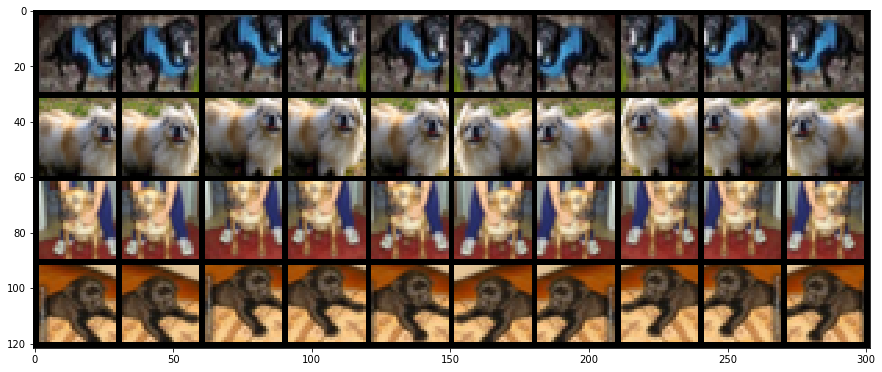

In [23]:
train_loader = DataLoader(train_set, batch_size=4)
images, _ = next(iter(train_loader))
images = images.view(-1, 3, 28, 28)
imgviz(images, save_fname="original_CIFAR10.png", nrow=10)

## Define model

In [24]:
class CriticNet(nn.Module):
    """
    A three hidden-layer critic neural network
    """
    def __init__(self):
        super(CriticNet, self).__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(3, 48, 3, 2, 1), # 48 14 14
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 96, 3, 2, 1), # 96 7 7
            nn.LeakyReLU(0.1),
            nn.Conv2d(96, 192, 3, 2, 1), # 192 4 4
            nn.LeakyReLU(0.1),
            nn.Flatten(start_dim=1),
            nn.Linear(192 * 4 * 4, 1)
        )

    def forward(self, inputs):
        output = self.layers(inputs)
        return output

In [25]:
class GeneratorNet(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features):
        super(GeneratorNet, self).__init__()
        
        self.linear = nn.Linear(n_features, 4 * 4 * 192)
        self.BN = nn.BatchNorm1d(4 * 4 * 192)
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(192, 96, 2, 2, 0), # 96 8 8
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 3, 2, 1), # 48 15 15
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 2, 2, 1), # 24 28 28
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 3, 3, 1, 1), # 1 28 28
            nn.Tanh()
        )

    def forward(self, inputs):
        linear = self.relu(self.BN(self.linear(inputs)))
        linear = linear.view(-1, 192, 4, 4)
        generated_img = self.layers(linear)
        return generated_img

In [26]:
class WGAN_GP(nn.Module):
    """
    A Generative Adversarial Network model.
    """
    def __init__(self, latent_dim, lambd=10):
        super(WGAN_GP, self).__init__()
        self.latent_dim = latent_dim
        self.lambd = lambd
        self.critic = CriticNet()
        self.generator = GeneratorNet(self.latent_dim)
        self.d_optimizer = None
        self.g_optimizer = None
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def set_optimizers(self, d_optimizer, g_optimizer):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
    def sample(self, batch_size):
        """
        Generates Gaussian sampled random values for image generation.
        """
        return Variable(torch.randn((batch_size, self.latent_dim)))
    
    def train_critic(self, data, train=True):
        """
        Trains critic model and returns WGAN loss and gradient penalty.
        """
        batch_size = data.size(0)
        samples = self.sample(batch_size)
        generated_data = self.generator(samples)
        gp = self.gradient_penalty(data, generated_data)
        d_loss = self.critic(generated_data).mean() - self.critic(data).mean() + gp
        self.d_optimizer.zero_grad()
        d_loss.backward()
        self.d_optimizer.step()
        return d_loss, gp
    
    def gradient_penalty(self, data, generated_data):
        """
        Calculates gradient penalty.
        """
        batch_size = data.size(0)
        #eps = torch.rand(batch_size, 1).expand_as(data)
        eps = torch.rand(batch_size, 1).expand_as(data.view((batch_size, -1)))
        eps = eps.view(batch_size, 3, 28, 28)
        
        interpolation = eps * data.data + (1 - eps) * generated_data.data
        interpolation = Variable(interpolation, requires_grad=True)

        interpolation_logits = self.critic(interpolation)
        grad_outputs = torch.ones(interpolation_logits.size())

        gradients = grad(outputs=interpolation_logits,
                         inputs=interpolation,
                         grad_outputs=grad_outputs,
                         create_graph=True,
                         retain_graph=True)[0]
        
        gradients = gradients.view(batch_size, -1)
        gp = self.lambd * ((gradients.norm(p=2, dim=1) - 1) ** 2).mean()
        return gp
    
    def train_generator(self, batch_size):
        """
        Trains generator model and returns generator loss.
        """
        samples = self.sample(batch_size)
        generated_data = self.generator(samples)
        g_loss = -self.critic(generated_data).mean()
        self.g_optimizer.zero_grad()
        g_loss.backward()
        self.g_optimizer.step()
        return g_loss
    
    def display(self, images, latents):
        """
        Displays real images and generated images.
        """
        print("Real images:")
        imgviz(images)
        
        with torch.no_grad():
            generated_images = self.generator(latents)
        print("Generated images:")
        imgviz(generated_images)

    def forward(self, inputs, train_generator=False):
        # Train critic
        data = Variable(inputs)
        d_loss, gp = self.train_critic(data)
        
        # If train_generator, train generator
        if train_generator:
            batch_size = data.size(0)
            g_loss = self.train_generator(batch_size)
            return d_loss, gp, g_loss
        else:
            return d_loss, gp

In [27]:
latent_dim = 64
print("Number of parameters in model with latent_dim={0}: {1}"
      .format(latent_dim, WGAN_GP(latent_dim).num_params))

Number of parameters in model with latent_dim=64: 538852


## Training

In [9]:
"""
parameters = OrderedDict(
    init_lr = [0.0001, 0.00005],
    batch_size = [128],
    latent_dim = [64],
    betas = [(0.5, 0.9), (0, 0.9), (0.9, 0.999)],
    lambd = [10, 5]
)
"""
param_names = ('init_lr', 'batch_size', 'latent_dim', 'betas', 'lambd')
parameters = OrderedDict(
    run1 = [0.0001, 13, 128, (0, 0.9), 10]
)

run  epoch     d_loss        gp     g_loss  epoch duration  \
0      1      1 -23.565876  7.591761  15.001285     1007.123669   
1      1      2 -17.480568  4.899219   8.092465     1080.911334   
2      1      3  -5.870459  0.707625   6.486454     1097.267326   
3      1      4  -3.746173  0.324958  -2.753532     1035.631202   
4      1      5  -3.038429  0.224439  -2.225491      977.010658   
5      1      6  -2.804354  0.187093  -2.983081      937.877484   
6      1      7  -2.842032  0.209504  -6.326458      943.708451   
7      1      8  -2.795327  0.204874  -8.413378      936.056827   
8      1      9  -2.708445  0.185477 -10.266524      967.385796   
9      1     10  -2.597814  0.165868 -11.639609      945.400936   
10     1     11  -2.537214  0.162974 -13.876535      976.465681   
11     1     12  -2.541018  0.167020 -15.555049      942.379496   
12     1     13  -2.525323  0.166592 -17.745584      939.125985   
13     1     14  -2.599314  0.180791 -19.508743      940.418928   
14     1     15  -2.651753  0.195012 -22.439126      975.137875   
15     1     16  -2.724669  0.206456 -23.988751      971.434378   
16     1     17  -2.791062  0.217429 -26.766994      959.036665   
17     1     18  -2.842642  0.236646 -28.894380      940.624206   
18     1     19  -2.880526  0.249260 -29.577000      938.541687   
19     1     20  -2.909775  0.257737 -31.262823      943.355123   
20     1     21  -2.894678  0.251973 -32.486792      938.535820   
21     1     22  -2.833148  0.246136 -32.553386      935.961167   
22     1     23  -2.778690  0.236270 -33.302404      959.265564   
23     1     24  -2.649082  0.221647 -32.926448      953.539680   
24     1     25  -2.502703  0.200045 -32.602286      938.810153   
25     1     26  -2.394462  0.176798 -33.440332      957.113071   
26     1     27  -2.249164  0.156853 -32.321012      940.137439   
27     1     28  -2.136846  0.138978 -31.232009      942.222617   
28     1     29  -2.085747  0.135715 -30.855141      934.896181   
29     1     30  -2.015990  0.123678 -30.626258      957.013776   
..   ...    ...        ...       ...        ...             ...   
120    1    121  -1.536795  0.099793  -6.771749      671.127533   
121    1    122  -1.529159  0.096326  -6.556826      640.748087   
122    1    123  -1.528139  0.097297  -6.235997      621.451929   
123    1    124  -1.527348  0.096899  -6.330687      619.296664   
124    1    125  -1.516941  0.095427  -6.232262      621.676555   
125    1    126  -1.512105  0.094983  -6.178765      621.281060   
126    1    127  -1.510676  0.095523  -5.899952      621.670412   
127    1    128  -1.510892  0.094230  -5.958528      619.963272   
128    1    129  -1.499054  0.094342  -5.956447      640.185312   
129    1    130  -1.511419  0.094625  -5.774992      618.593575   
130    1    131  -1.492600  0.093435  -5.576020      634.853175   
131    1    132  -1.494218  0.093037  -5.600355      623.232794   
132    1    133  -1.500003  0.094320  -5.264923      623.563851   
133    1    134  -1.486214  0.092827  -5.350324      620.802746   
134    1    135  -1.488252  0.093537  -5.422934      638.976114   
135    1    136  -1.482812  0.092733  -4.951445      621.284480   
136    1    137  -1.477477  0.093549  -4.848295      620.245341   
137    1    138  -1.474833  0.091881  -4.774163      621.865863   
138    1    139  -1.463831  0.091734  -4.713810      620.023279   
139    1    140  -1.474195  0.092372  -4.625358      621.302251   
140    1    141  -1.466794  0.090886  -4.350317      690.619765   
141    1    142  -1.451519  0.089973  -4.572310      636.685456   
142    1    143  -1.456056  0.090096  -4.099785      639.692849   
143    1    144  -1.464161  0.092001  -4.238220      621.402262   
144    1    145  -1.448079  0.088799  -4.337914      622.981726   
145    1    146  -1.468769  0.089171  -4.245585      639.195823   
146    1    147  -1.450455  0.093259  -3.906207      620.411485   
147    1    148  -1.440301  0.087649  -4.272554     

Real images:


<Figure size 1080x1080 with 0 Axes>

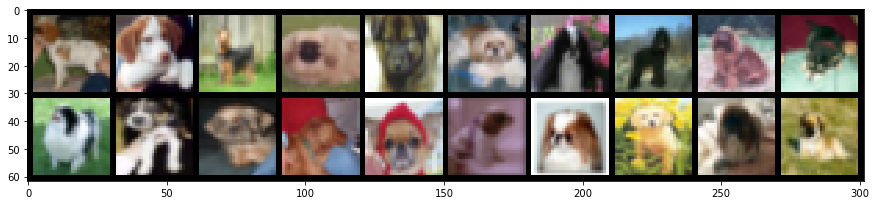

Generated images:


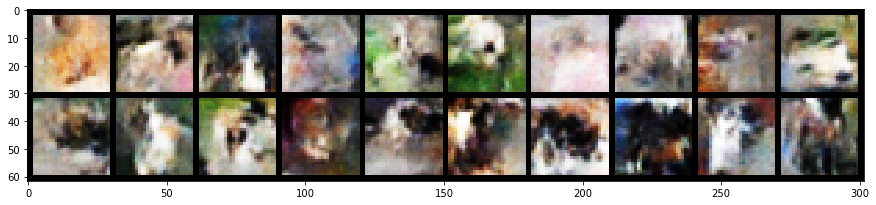

Model has finished training.

Training completed.


In [10]:
m = RunManager()
num_epochs = 150
num_samples = 20
num_critic_iters = 5

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a GAN model
    model = WGAN_GP(hparams.latent_dim, lambd=hparams.lambd)

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=num_samples)
    test_images, _ = next(iter(test_loader))
    
    # Define random samples from standard Normal distribution for image generation
    test_latents = torch.randn((num_samples, hparams.latent_dim))
    
    # Define optimizers
    d_optimizer = optim.Adam(model.critic.parameters(), lr=hparams.init_lr, betas=hparams.betas)
    g_optimizer = optim.Adam(model.generator.parameters(), lr=hparams.init_lr, betas=hparams.betas)
    d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, 60, 0.1)
    g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, 60, 0.1)
    model.set_optimizers(d_optimizer, g_optimizer)
    
    # Setup run instance
    m.begin_run(hparams, model, test_images, test_latents)
    model.display(test_images, test_latents)
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, latent_dim={2}, betas={3}, lambda={4}'
         .format(hparams.init_lr, hparams.batch_size, hparams.latent_dim, hparams.betas, hparams.lambd))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            images, _ = batch
            images = images.view(-1, 3, 28, 28)

            # Calculating the loss
            if i % num_critic_iters == 0:
                d_loss, gp, g_loss = model(images, train_generator=True)
            else:
                d_loss, gp = model(images, train_generator=False)
                g_loss = None
            
            if i % 10 == 0:
                print('Epoch {0}, iteration {1}: d_loss {2}, gp {3}, g_loss {4}'
                      .format(epoch+1, i*hparams.batch_size * 10,
                              round(d_loss.item(), 6),
                              round(gp.item(), 6),
                              round(g_loss.item(), 6)))

            m.track_loss(d_loss, gp, g_loss)
            
        m.end_epoch()
    
    #torch.save(model, './models/' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    d_scheduler.step()
    g_scheduler.step()
    
m.save('results_CIFAR_final')
print("Training completed.")

## Produce generated examples

Latent dimension index: 0


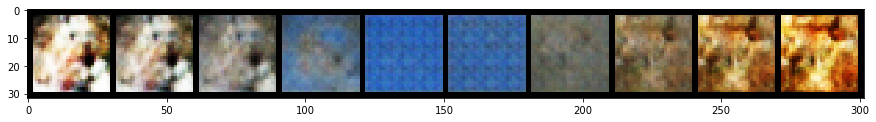

Latent dimension index: 1


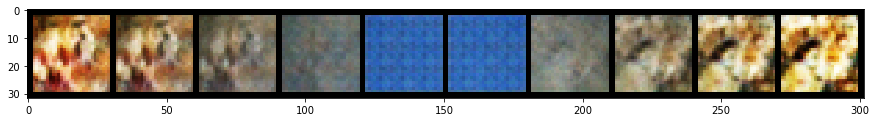

Latent dimension index: 2


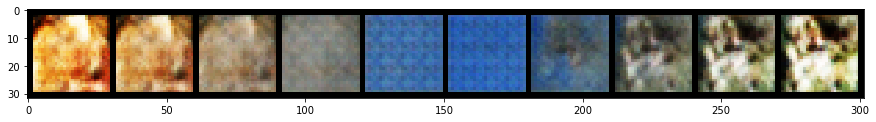

Latent dimension index: 3


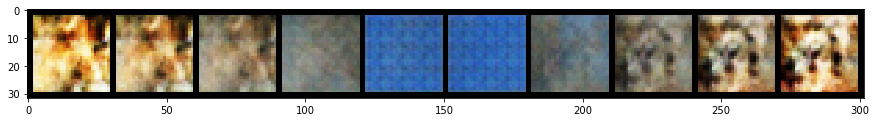

Latent dimension index: 4


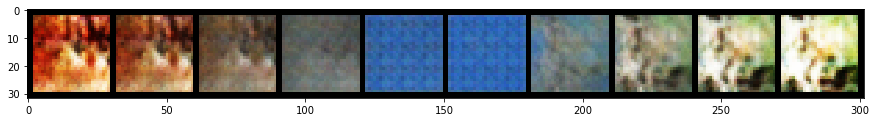

Latent dimension index: 5


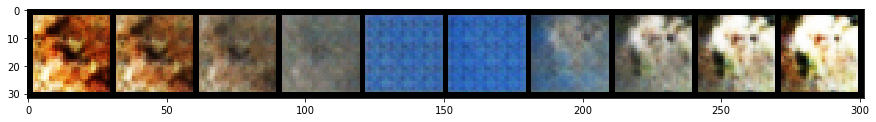

Latent dimension index: 6


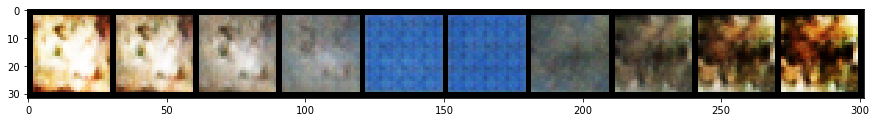

Latent dimension index: 7


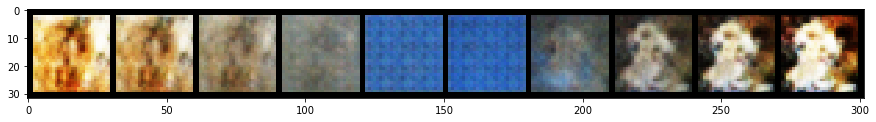

Latent dimension index: 8


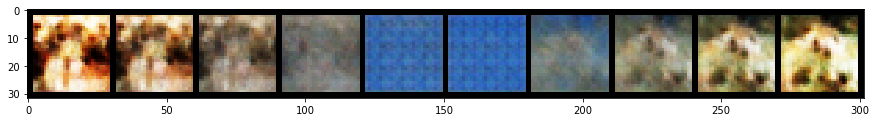

Latent dimension index: 9


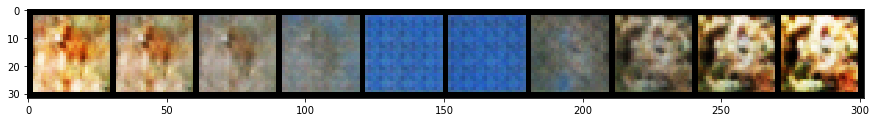

Latent dimension index: 10


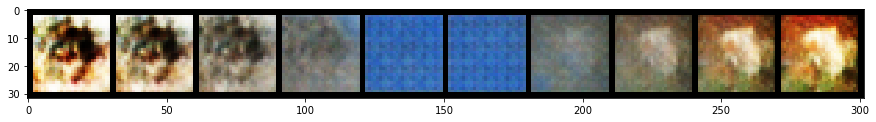

Latent dimension index: 11


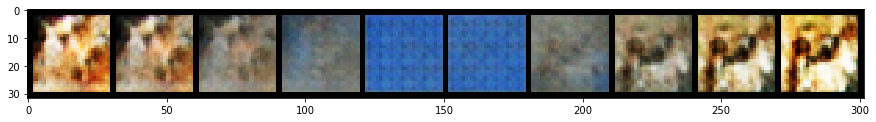

Latent dimension index: 12


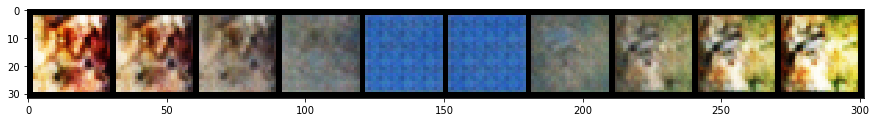

Latent dimension index: 13


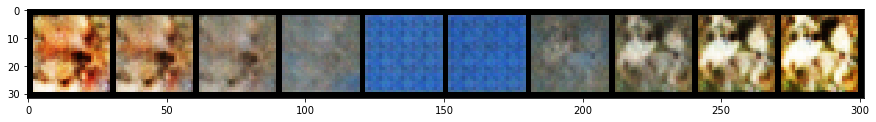

Latent dimension index: 14


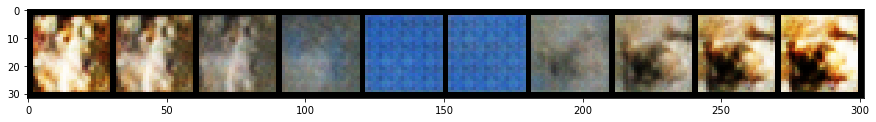

Latent dimension index: 15


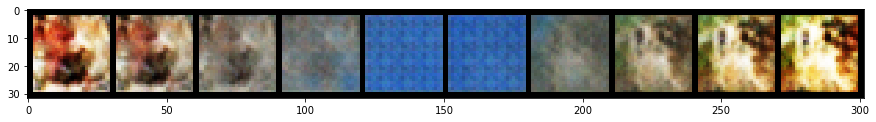

Latent dimension index: 16


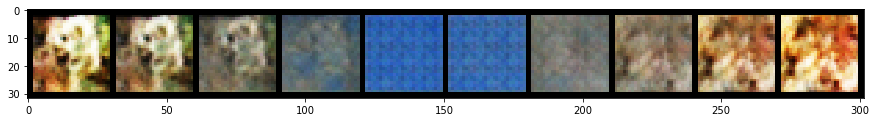

Latent dimension index: 17


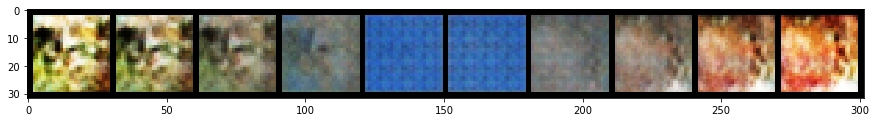

Latent dimension index: 18


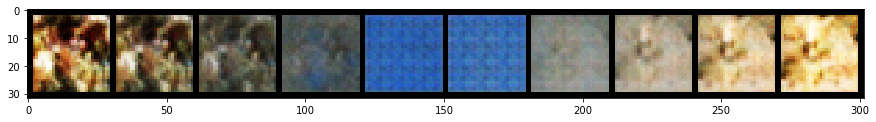

Latent dimension index: 19


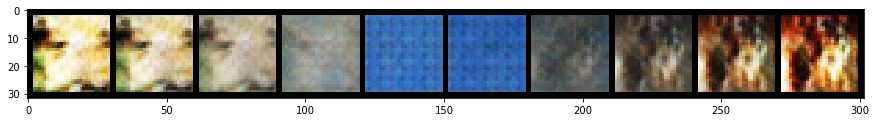

Latent dimension index: 20


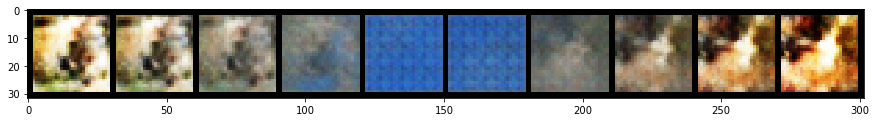

Latent dimension index: 21


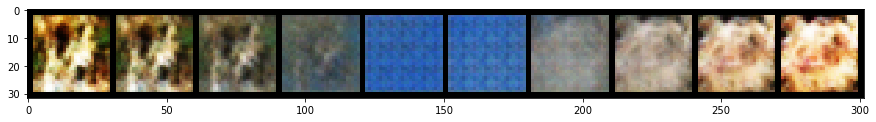

Latent dimension index: 22


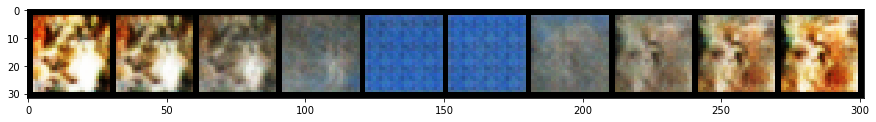

Latent dimension index: 23


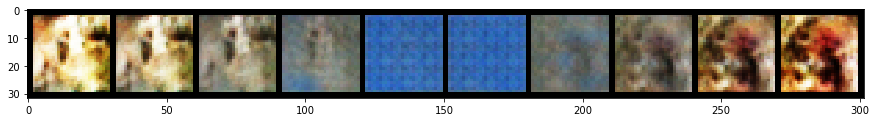

Latent dimension index: 24


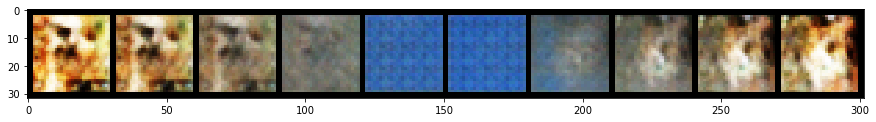

Latent dimension index: 25


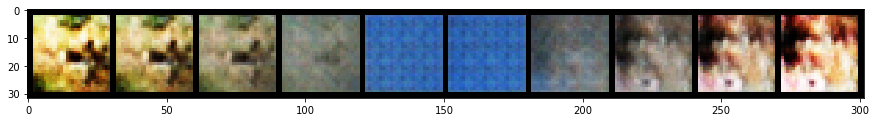

Latent dimension index: 26


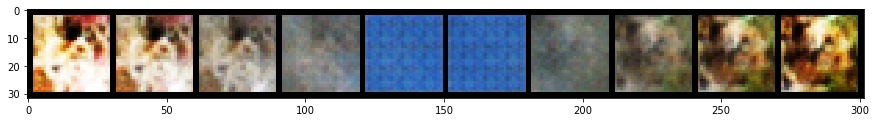

Latent dimension index: 27


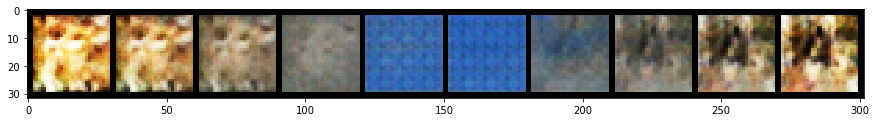

Latent dimension index: 28


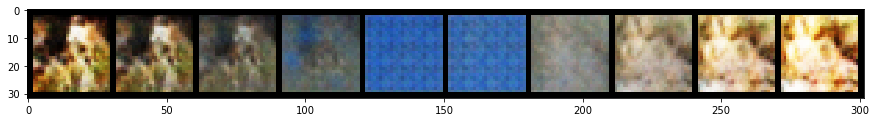

Latent dimension index: 29


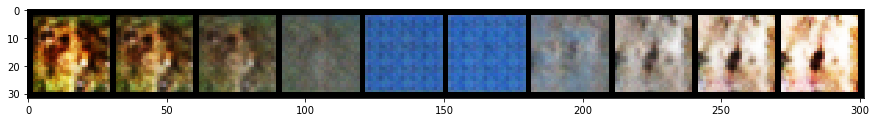

Latent dimension index: 30


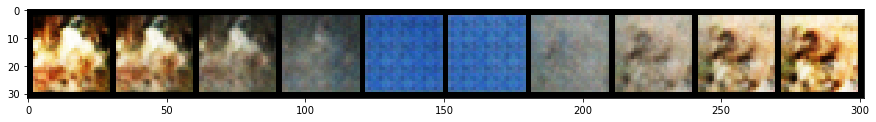

Latent dimension index: 31


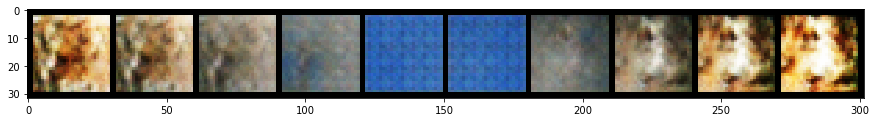

Latent dimension index: 32


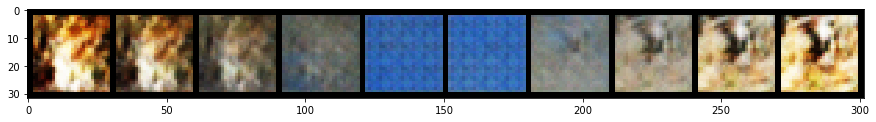

Latent dimension index: 33


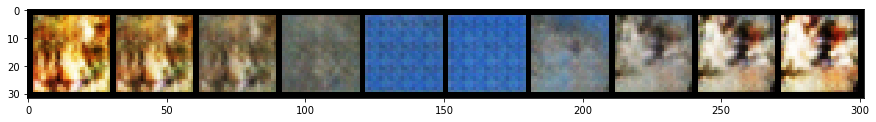

Latent dimension index: 34


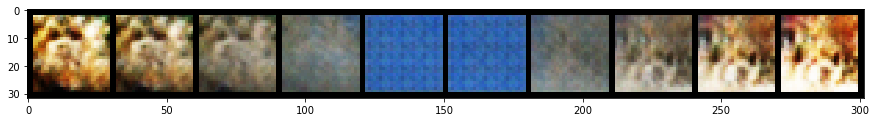

Latent dimension index: 35


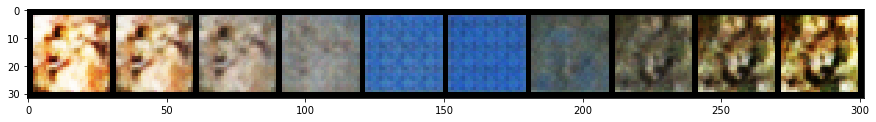

Latent dimension index: 36


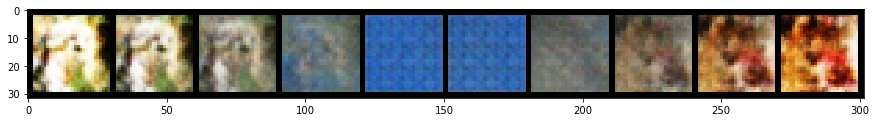

Latent dimension index: 37


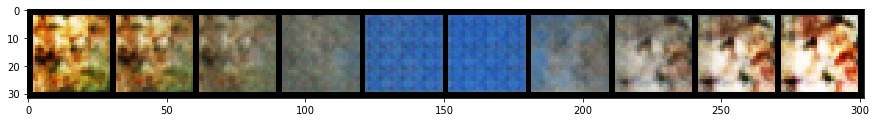

Latent dimension index: 38


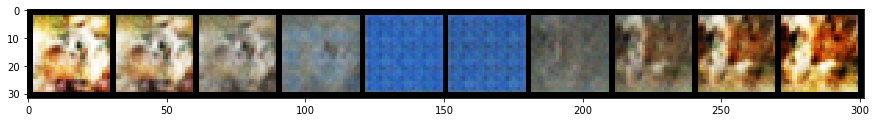

Latent dimension index: 39


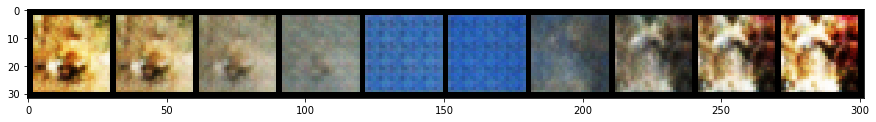

Latent dimension index: 40


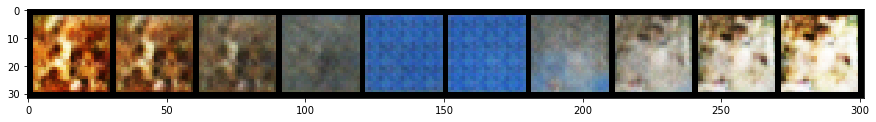

Latent dimension index: 41


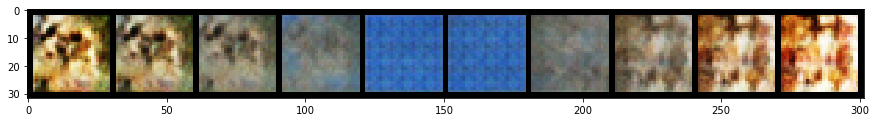

Latent dimension index: 42


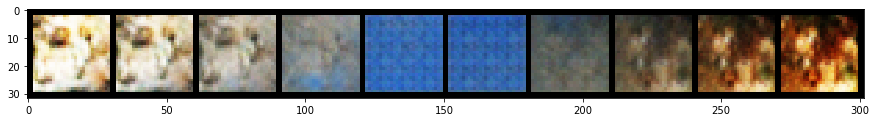

Latent dimension index: 43


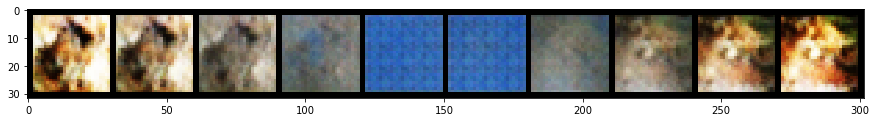

Latent dimension index: 44


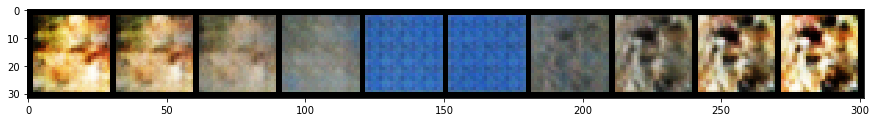

Latent dimension index: 45


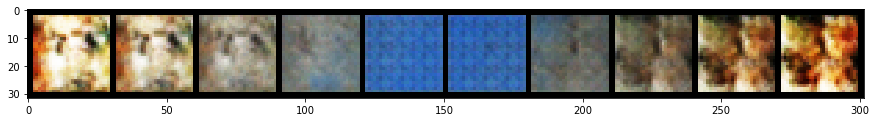

Latent dimension index: 46


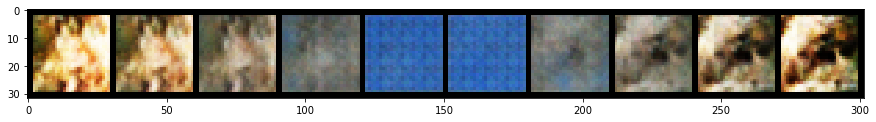

Latent dimension index: 47


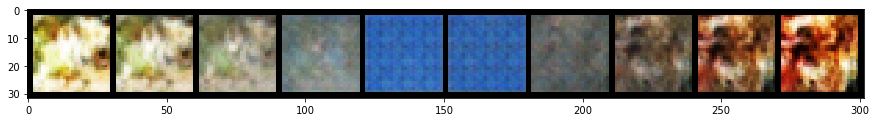

Latent dimension index: 48


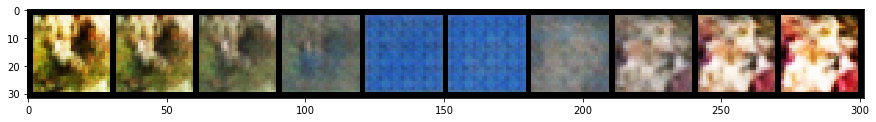

Latent dimension index: 49


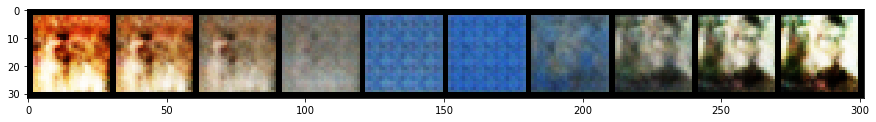

Latent dimension index: 50


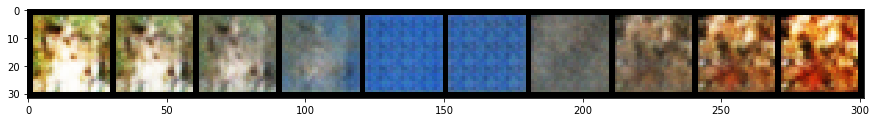

Latent dimension index: 51


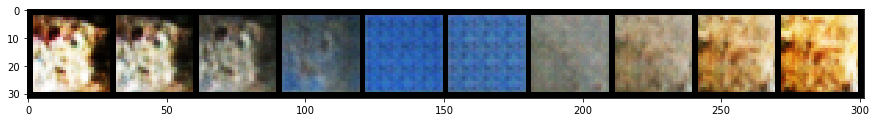

Latent dimension index: 52


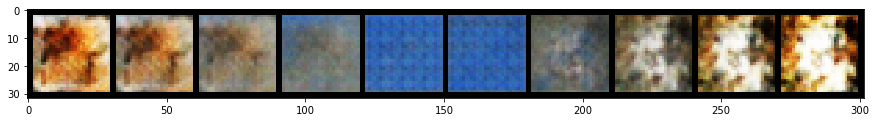

Latent dimension index: 53


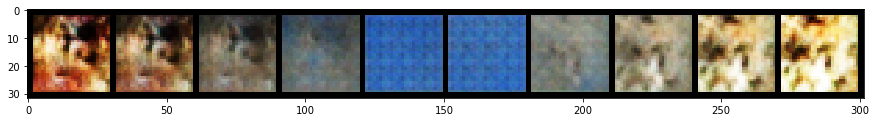

Latent dimension index: 54


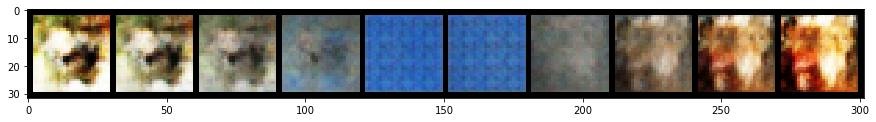

Latent dimension index: 55


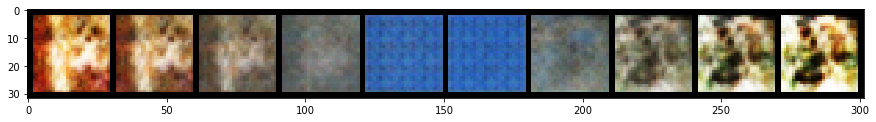

Latent dimension index: 56


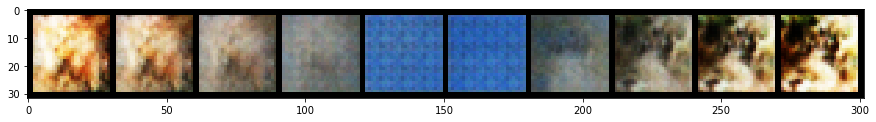

Latent dimension index: 57


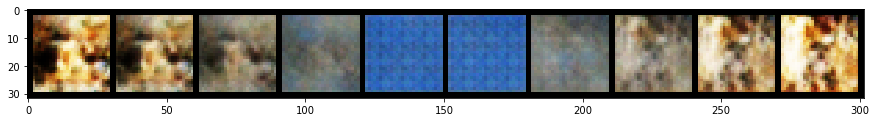

Latent dimension index: 58


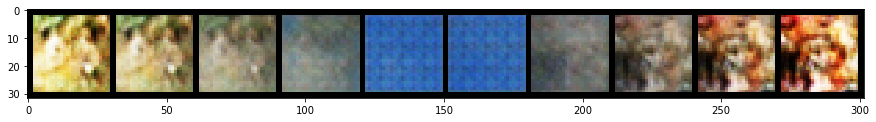

Latent dimension index: 59


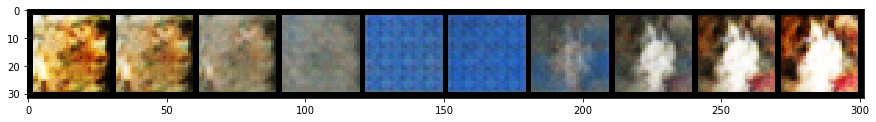

Latent dimension index: 60


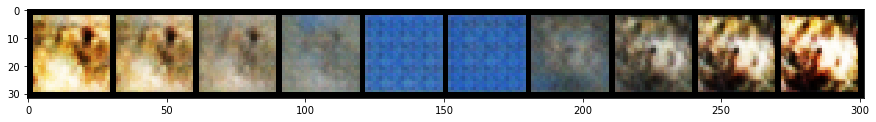

Latent dimension index: 61


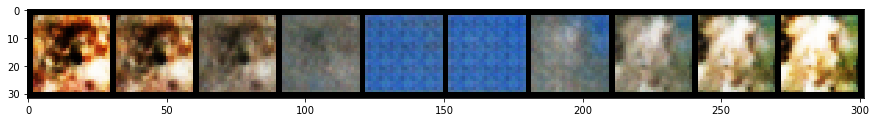

Latent dimension index: 62


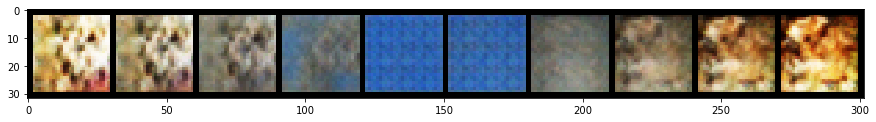

Latent dimension index: 63


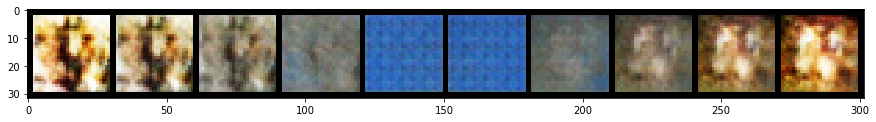

Latent dimension index: 64


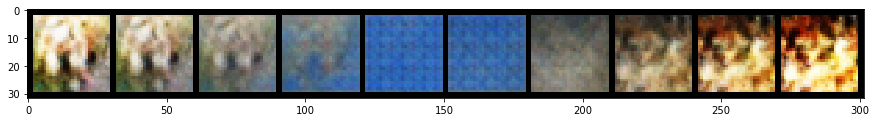

Latent dimension index: 65


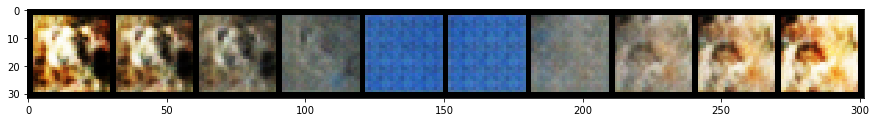

Latent dimension index: 66


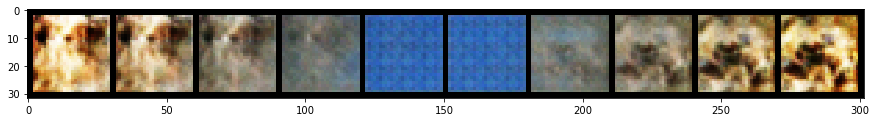

Latent dimension index: 67


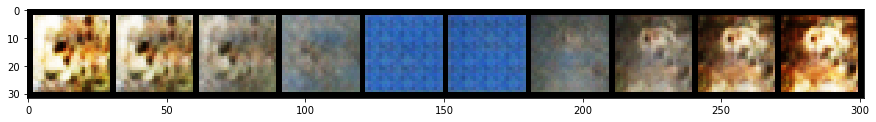

Latent dimension index: 68


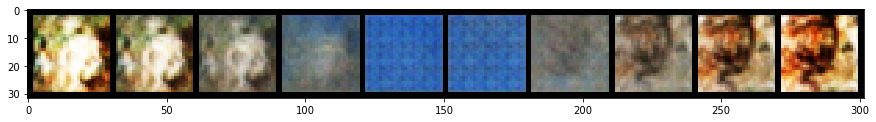

Latent dimension index: 69


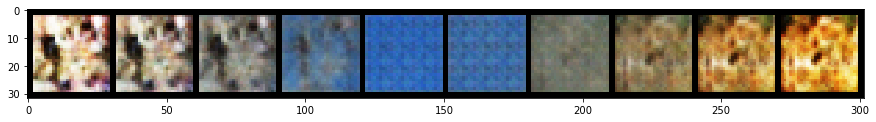

Latent dimension index: 70


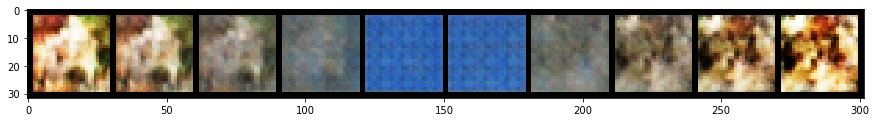

Latent dimension index: 71


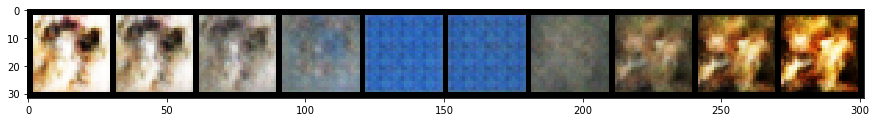

Latent dimension index: 72


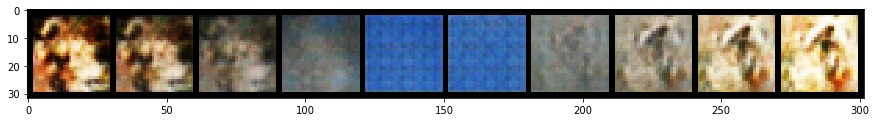

Latent dimension index: 73


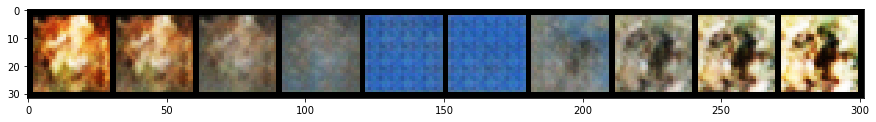

Latent dimension index: 74


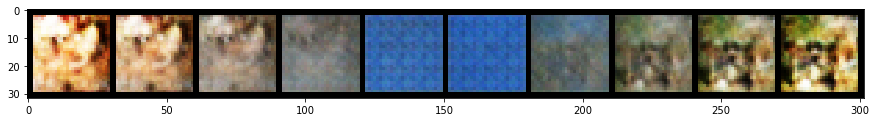

Latent dimension index: 75


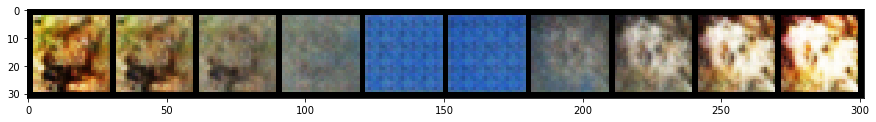

Latent dimension index: 76


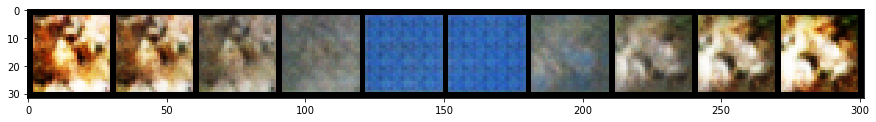

Latent dimension index: 77


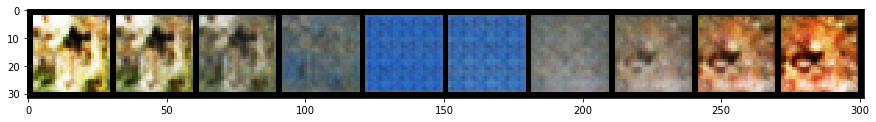

Latent dimension index: 78


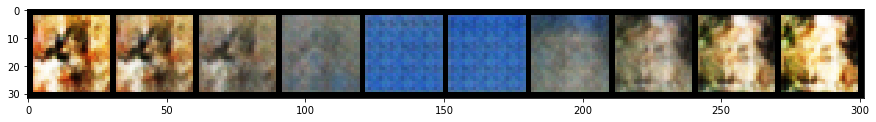

Latent dimension index: 79


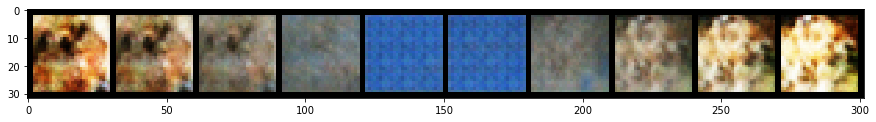

Latent dimension index: 80


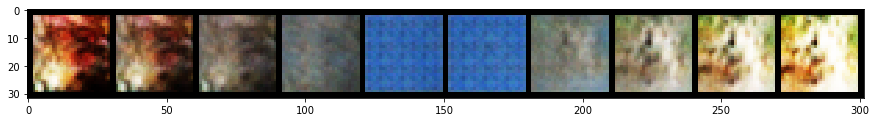

Latent dimension index: 81


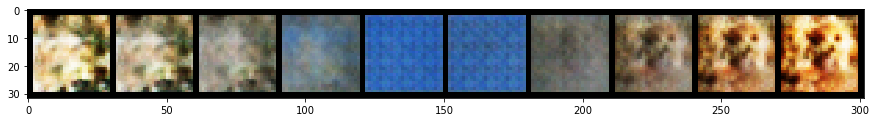

Latent dimension index: 82


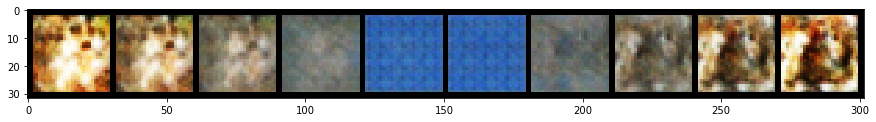

Latent dimension index: 83


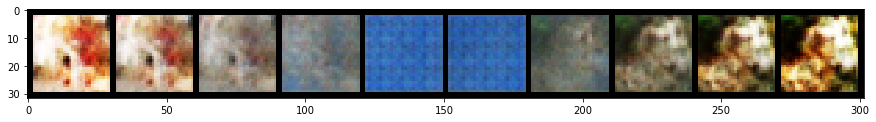

Latent dimension index: 84


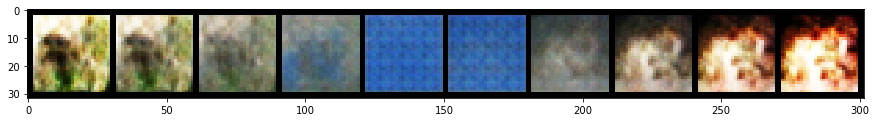

Latent dimension index: 85


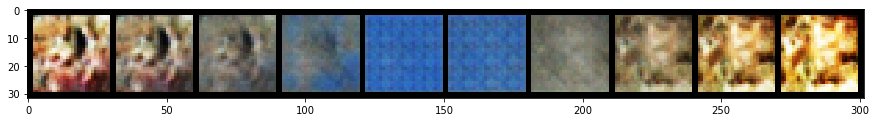

Latent dimension index: 86


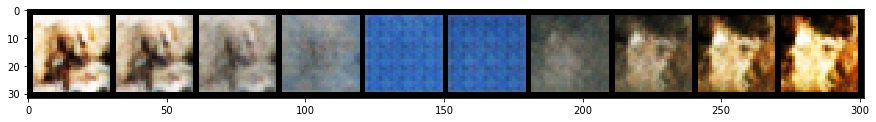

Latent dimension index: 87


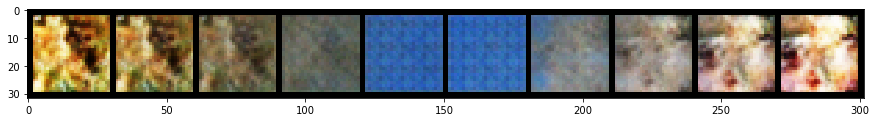

Latent dimension index: 88


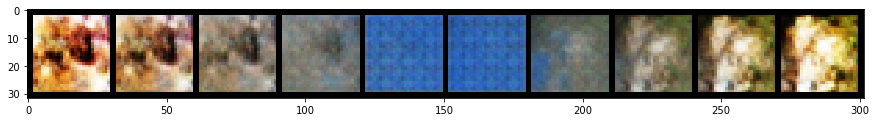

Latent dimension index: 89


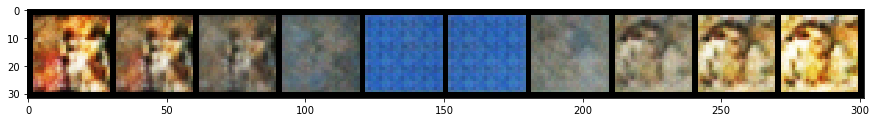

Latent dimension index: 90


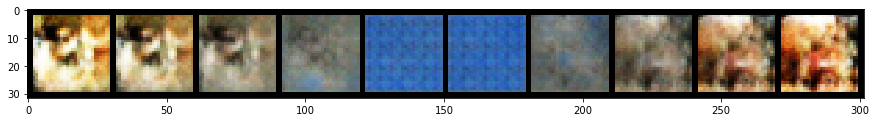

Latent dimension index: 91


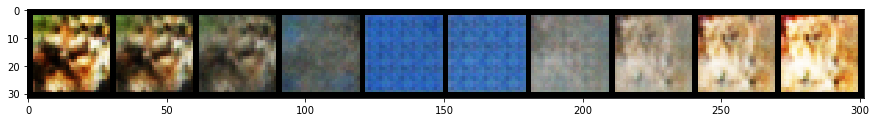

Latent dimension index: 92


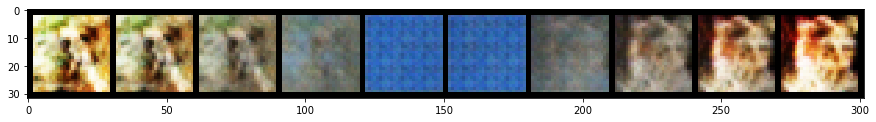

Latent dimension index: 93


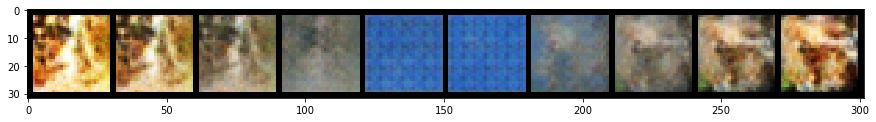

Latent dimension index: 94


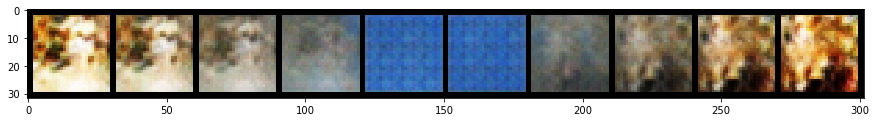

Latent dimension index: 95


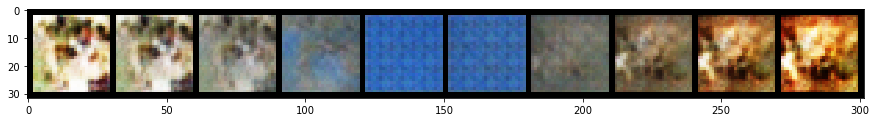

Latent dimension index: 96


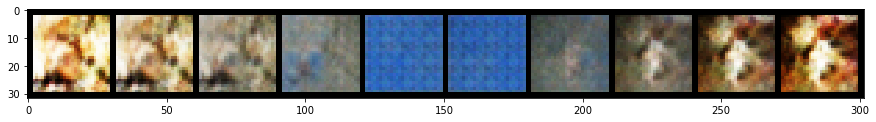

Latent dimension index: 97


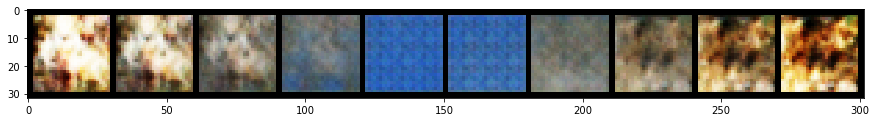

Latent dimension index: 98


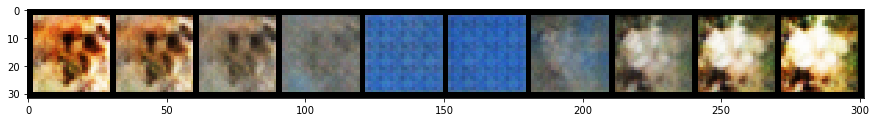

Latent dimension index: 99


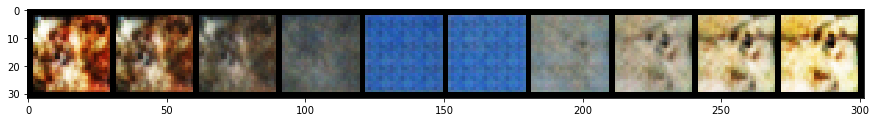

Latent dimension index: 100


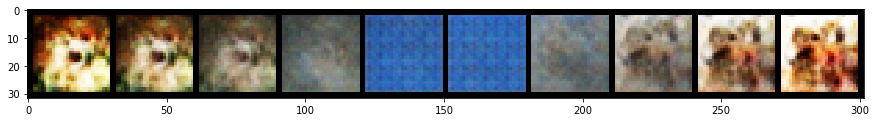

Latent dimension index: 101


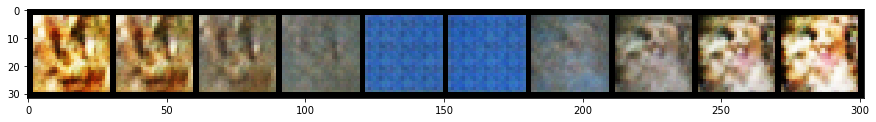

Latent dimension index: 102


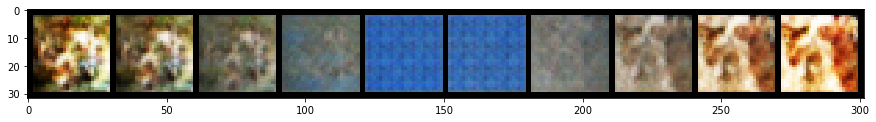

Latent dimension index: 103


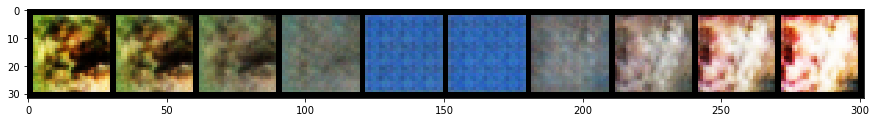

Latent dimension index: 104


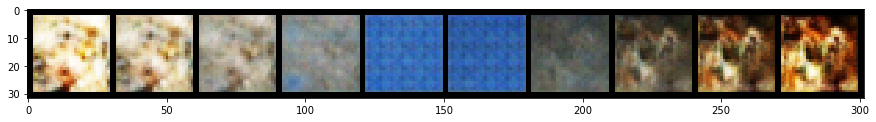

Latent dimension index: 105


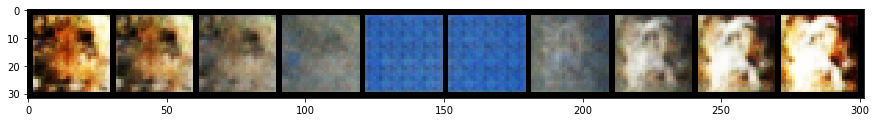

Latent dimension index: 106


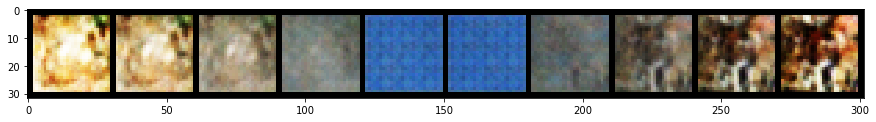

Latent dimension index: 107


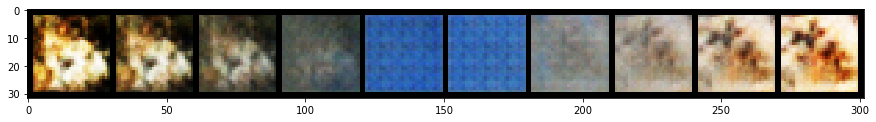

Latent dimension index: 108


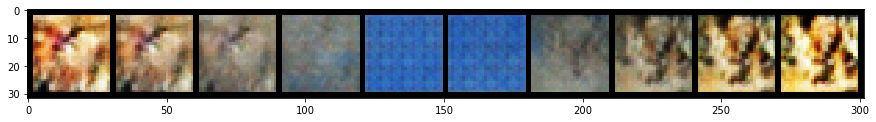

Latent dimension index: 109


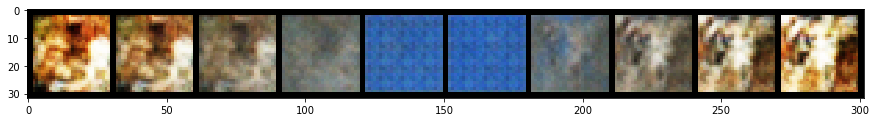

Latent dimension index: 110


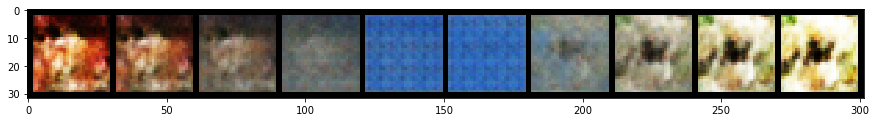

Latent dimension index: 111


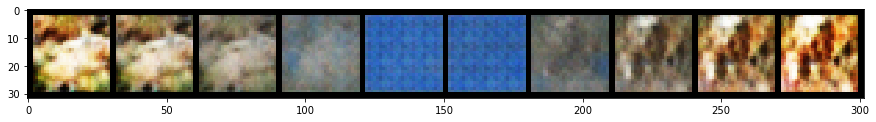

Latent dimension index: 112


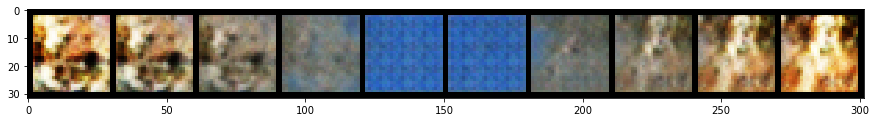

Latent dimension index: 113


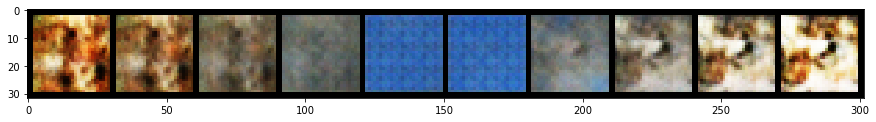

Latent dimension index: 114


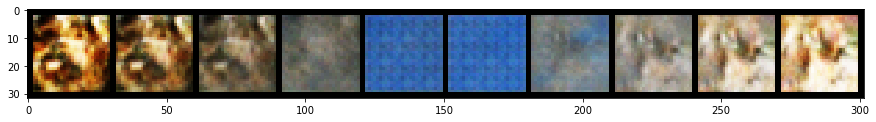

Latent dimension index: 115


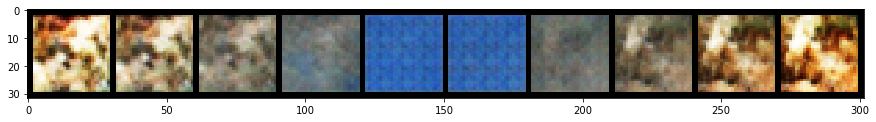

Latent dimension index: 116


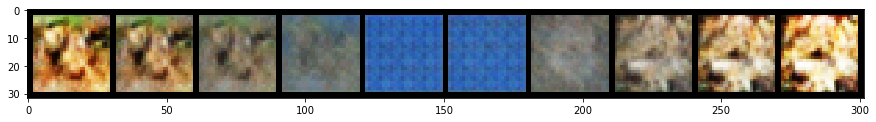

Latent dimension index: 117


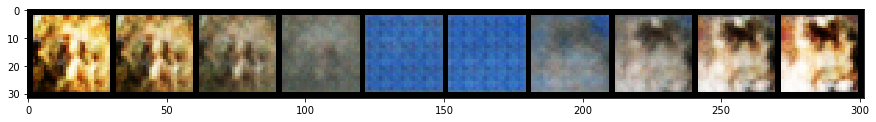

Latent dimension index: 118


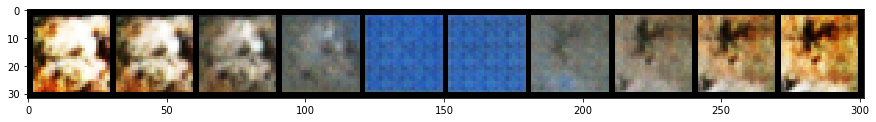

Latent dimension index: 119


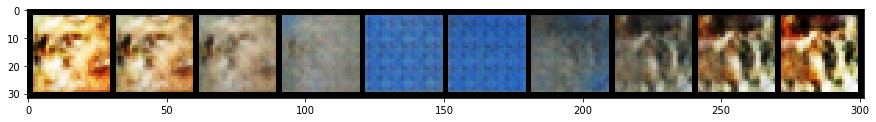

Latent dimension index: 120


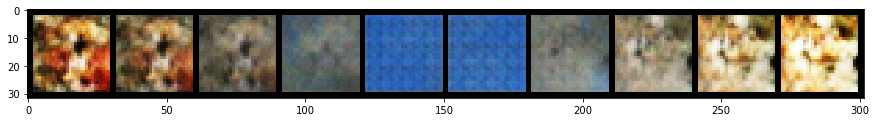

Latent dimension index: 121


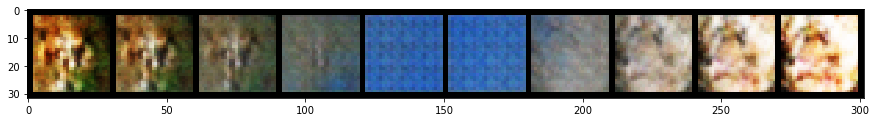

Latent dimension index: 122


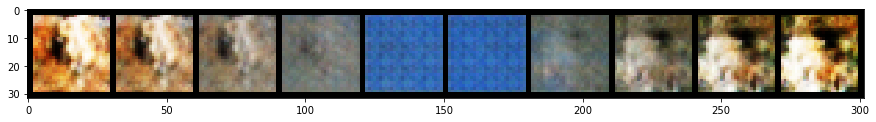

Latent dimension index: 123


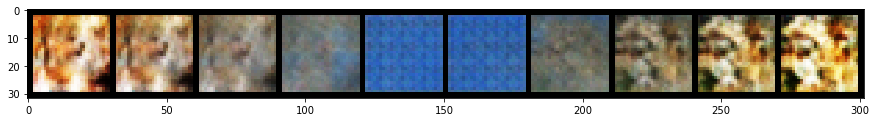

Latent dimension index: 124


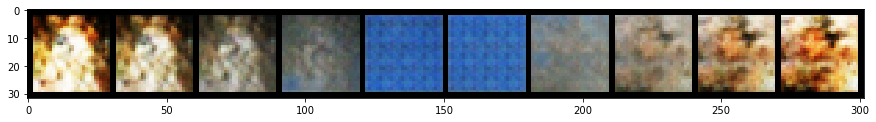

Latent dimension index: 125


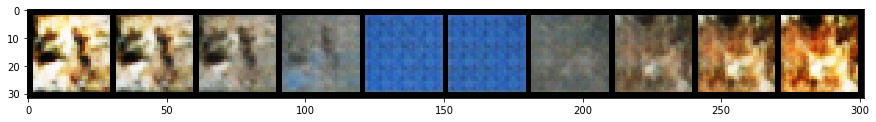

Latent dimension index: 126


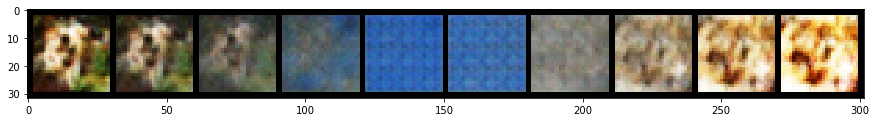

Latent dimension index: 127


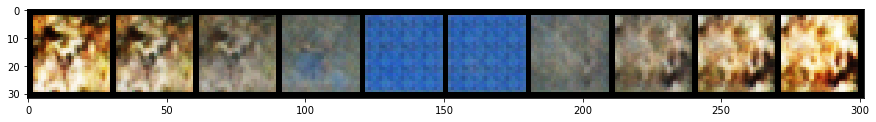

In [11]:
zs = np.linspace(-3, 3, 10)
for j in range(model.latent_dim):
    latents = torch.zeros((10, model.latent_dim))
    for i in range(10):
        latents[i,j] = zs[i]
    print("Latent dimension index:", j)
    with torch.no_grad():
        generated_imgs = model.generator(latents)
        imgviz(generated_imgs)

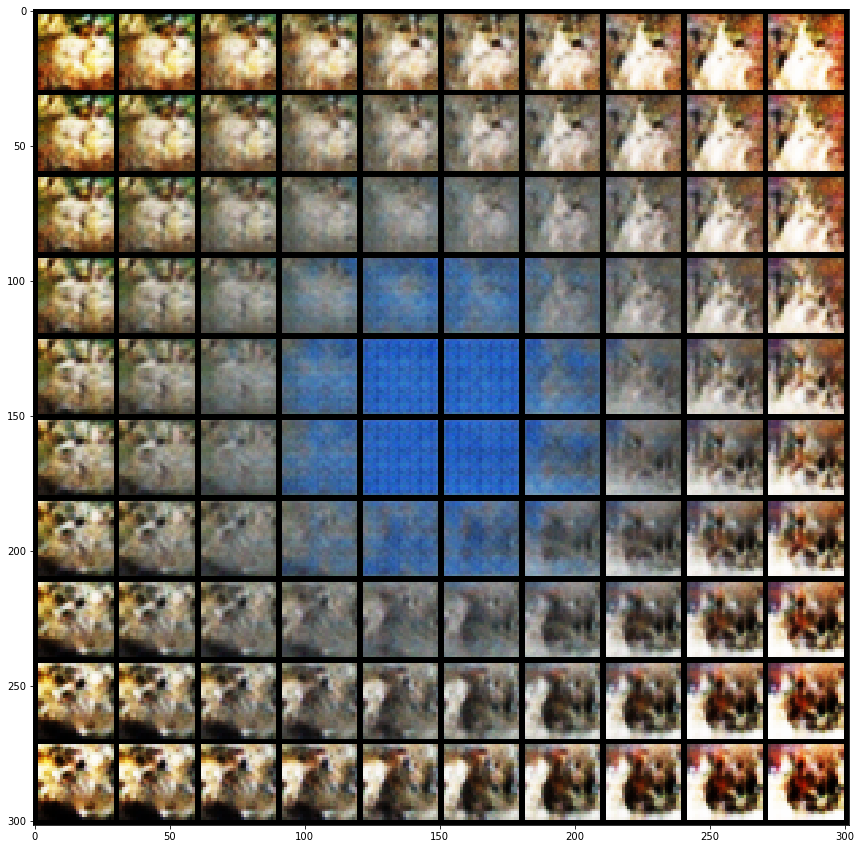

In [18]:
a = np.linspace(-3, 3, 10)
b0, b1 = np.meshgrid(a, a)
latents = torch.zeros((100, model.latent_dim))
for i in range(10):
    for j in range(10):
        latents[i*10+j,34] = b0[i,j]
        latents[i*10+j,82] = b1[i,j]
with torch.no_grad():
    generated_imgs = model.generator(latents)
    imgviz(generated_imgs, save_fname='CIFAR_img.png')

## Losses

In [16]:
import pandas as pd

In [17]:
## Visualise losses in graph
df = pd.read_csv('./results_CIFAR_final.csv', index_col=0)
epochs = np.array(list(range(3, 151)))
df.head()

run  epoch     d_loss        gp     g_loss  epoch duration  run duration  \
0    1      1 -23.565876  7.591761  15.001285     1007.123669   1010.495046   
1    1      2 -17.480568  4.899219   8.092465     1080.911334   2092.721092   
2    1      3  -5.870459  0.707625   6.486454     1097.267326   3191.215797   
3    1      4  -3.746173  0.324958  -2.753532     1035.631202   4228.140034   
4    1      5  -3.038429  0.224439  -2.225491      977.010658   5206.416589   

   init_lr  batch_size  latent_dim     betas  lambd  
0   0.0001         130         128  (0, 0.9)     10  
1   0.0001         130         128  (0, 0.9)     10  
2   0.0001         130         128  (0, 0.9)     10  
3   0.0001         130         128  (0, 0.9)     10  
4   0.0001         130         128  (0, 0.9)     10

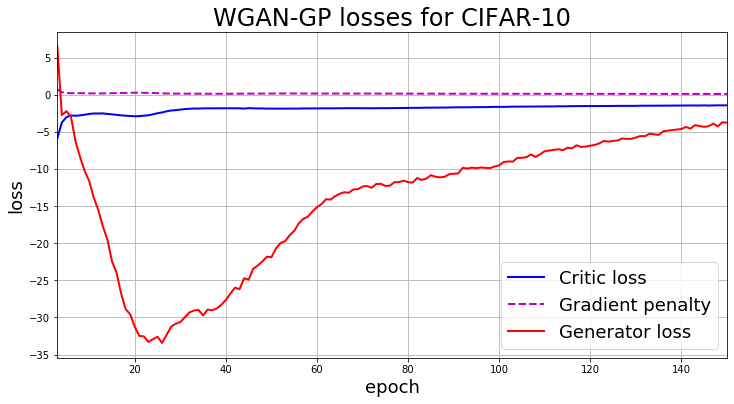

In [19]:
figure = plt.figure(figsize=(12,6))
plt.plot(epochs, df.d_loss[2:], 'b-', lw=2, label='Critic loss')
plt.plot(epochs, df.gp[2:], 'm--', lw=2, label='Gradient penalty')
plt.plot(epochs, df.g_loss[2:], 'r-', lw=2, label='Generator loss')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.title('WGAN-GP losses for CIFAR-10', fontsize=24)
plt.xlim([3,150])
plt.legend(fontsize=18)
plt.grid('on')
plt.savefig('./losses_CIFAR')
plt.show()